In [1]:
import numpy as np
import qililab as ql

## ugly solution because we have not created a proper package
import sys

sys.path.insert(1, "../utils")

from qst_qpt_helper_functions import *

from qiboconnection.api import API
from qiboconnection.connection import ConnectionConfiguration

from qililab.utils import from_dict

import matplotlib.pyplot as plt

from scipy.optimize import curve_fit


api = API(ConnectionConfiguration(username="qat", api_key="meow"))

api.select_device_id(9)

2024-03-08 10:56:35,361 - qm - INFO     - Starting session: 1d6a96eb-07c4-4618-b0b0-6e8f7c1d65b9


Is setting the logger perhaps a bit ugly for remote users to have to do manually? I have not seen any experiment where it is preferred to not be set to a higher level

In [2]:
ql.logger.setLevel(40)  # Set qililab's logger to a higher level so it only shows error messages

In [89]:
QUBIT = 0

In [91]:
runcard = api.get_runcard(runcard_name="galadriel_qprogram")
runcard_as_dict = runcard.runcard

In [92]:
RO_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["duration"]
RO_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"M({QUBIT})"][0]["pulse"]["amplitude"]
X_duration_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["duration"]
X_num_sigmas_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"]["num_sigmas"]
X_drag_coefficient_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["shape"][
    "drag_coefficient"
]
X_amplitude_runcard = runcard_as_dict["gates_settings"]["gates"][f"Drag({QUBIT})"][0]["pulse"]["amplitude"]

In [93]:
print(
    "drag params:\n \t amplitude",
    X_amplitude_runcard,
    "    duration",
    X_duration_runcard,
    "    drag coeff",
    X_drag_coefficient_runcard,
    "    sigmas",
    X_num_sigmas_runcard,
)
print("RO params:\n \t amplitude", RO_amplitude_runcard, "\t           duration", RO_duration_runcard)

drag params:
 	 amplitude 0.1307941088404597     duration 40     drag coeff -0.14746988653355642     sigmas 4
RO params:
 	 amplitude 0.0513 	           duration 2500


In [143]:
shots = 14000

wait_start = 0
wait_stop = 70000
wait_step = 2000  # 1750#1000  # 2_000


## Vyron's waveforms
# control_wf = ql.Gaussian(amplitude=1, duration=X_duration_runcard, num_sigmas=X_num_sigmas_runcard) ## from rabi program, setting gain in qprogram
control_wf = ql.IQPair.DRAG(
    amplitude=1.0 * X_amplitude_runcard,  ## because it's a pi pulse
    duration=X_duration_runcard,
    num_sigmas=X_num_sigmas_runcard,
    drag_coefficient=X_drag_coefficient_runcard,
)
# readout_wf = ql.Square(amplitude=1.0 * RO_amplitude_runcard, duration=RO_duration_runcard)  ## from Rabi program
readout_wf = ql.IQPair(
    I=ql.Square(amplitude=1.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
    Q=ql.Square(amplitude=0.0 * RO_amplitude_runcard, duration=RO_duration_runcard),
)

time_of_flight = (
    120  ## approximate time it takes for the pulse to reach the set-up, before that we'll just measure noise.
)

acquisition_weights_duration = RO_duration_runcard  # 2000 ## this is how Vyron had it
acquisition_weights = ql.IQPair(
    I=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
    Q=ql.Square(amplitude=1.0, duration=acquisition_weights_duration),
)

qubit_relaxation_duration = 200_000  # 200_000

In [144]:
qp = ql.QProgram(disable_autosync=True)
wait_variable = qp.variable(ql.Domain.Time)
with qp.average(shots=shots):
    with qp.for_loop(variable=wait_variable, start=wait_start, stop=wait_stop, step=wait_step):
        # qp.set_gain(bus=f"drive_q{QUBIT}_bus", gain=X_amplitude_runcard)
        qp.play(bus=f"drive_q{QUBIT}_bus", waveform=control_wf)  ## apply X gate
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=wait_variable)  # wait
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=time_of_flight)  # wait for the RO pulse to get to the fridge
        ### TODO: seems like I would need the precise number here, otherwise drive and readout will be out of sync
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=acquisition_weights.get_duration())
        qp.wait(bus=f"drive_q{QUBIT}_bus", duration=qubit_relaxation_duration)

        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=control_wf.get_duration())  ## wait for X pulse
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=wait_variable)  ## wait for wait time
        qp.play(bus=f"readout_q{QUBIT}_bus", waveform=readout_wf, wait_time=time_of_flight)  ## send readout pulse
        qp.acquire(bus=f"readout_q{QUBIT}_bus", weights=acquisition_weights)
        qp.wait(bus=f"readout_q{QUBIT}_bus", duration=qubit_relaxation_duration)

full_qprogram = qp.to_dict()

In [145]:
result_id = api.execute(qprogram=full_qprogram)[0]
print(result_id)

9692


### Post-processing of data is now going to the same function as if it were coming from a circuit, but the post-processing will likely have to be different.

In [147]:
results = api.get_result(result_id)

{
  "title": "Unauthorized",
  "status": 401,
  "detail": "JWTExpired: Error verifying the authorisation access token. Expired at 1709902589, time: 1709908147(leeway: 60) 401 Client Error:  for url: https://qilimanjaroqaas.ddns.net:8080/api/v1/jobs/9692"
}
{"title":"Unauthorized","status":401,"detail":"JWTExpired: Error verifying the authorisation access token. Expired at 1709902589, time: 1709908147(leeway: 60)"}

Your job with id 9692 is completed.


In [148]:
qprogram_results = from_dict(results)

array([[ 5.34436388,  5.28029507,  5.19672329,  5.13082022,  5.07025776,
         5.02416505,  4.96276502,  4.94212098,  4.8736989 ,  4.81451047,
         4.77771631,  4.74613829,  4.70891168,  4.67888736,  4.64714265,
         4.58433994,  4.5547415 ,  4.5307474 ,  4.51549724,  4.46407345,
         4.44256431,  4.42965797,  4.39774349,  4.39795673,  4.37416072,
         4.33293733,  4.30397645,  4.29354732,  4.29225431,  4.25487623,
         4.245819  ,  4.22283373,  4.22131321,  5.34341437,  5.24167402,
         5.17854972],
       [-3.50799368, -3.39075309, -3.27592044, -3.14132801, -3.04933701,
        -2.96644794, -2.85554407, -2.79288077, -2.71503095, -2.60901727,
        -2.55064258, -2.49871048, -2.45387469, -2.37763857, -2.33050953,
        -2.25501678, -2.2173391 , -2.1420856 , -2.10458874, -2.06364495,
        -2.01386601, -1.97551633, -1.95557415, -1.94635589, -1.88169597,
        -1.85487777, -1.81128414, -1.78347516, -1.76824032, -1.74996329,
        -1.71305841, -1.66495

In [149]:
i_vec, q_vec = qprogram_results.results[f"readout_q{QUBIT}_bus"][0].array  ## i, q
# i_vec, q_vec = qprogram_results.results['readout_q0_bus'][0].array ## i, q

v_vec = 20 * np.log10(np.sqrt(i_vec**2 + q_vec**2))

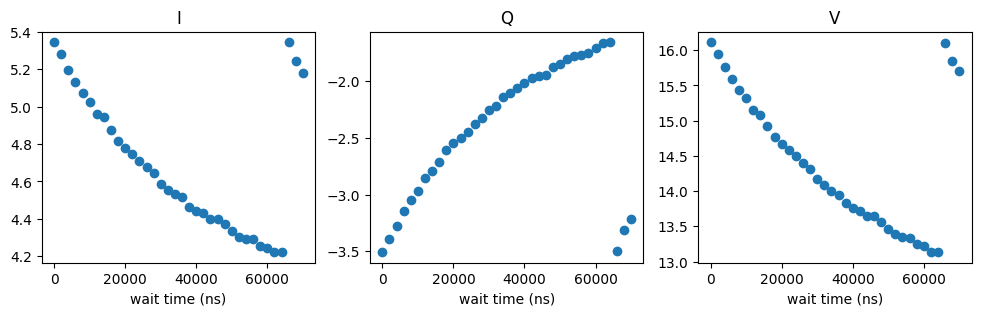

In [150]:
# Wait_duration_list = np.linspace(Wait_start, Wait_stop, Wait_step, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
data = [i_vec, q_vec, v_vec]
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
titles = ["I", "Q", "V"]

for i in range(3):
    axes[i].plot(xaxis, data[i], "o")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("wait time (ns)")
# plt.figure(figsize=(3, 3))
# plt.plot(i_vec, q_vec, "o")
# plt.xlabel("I")
# plt.ylabel("Q")

Previous id

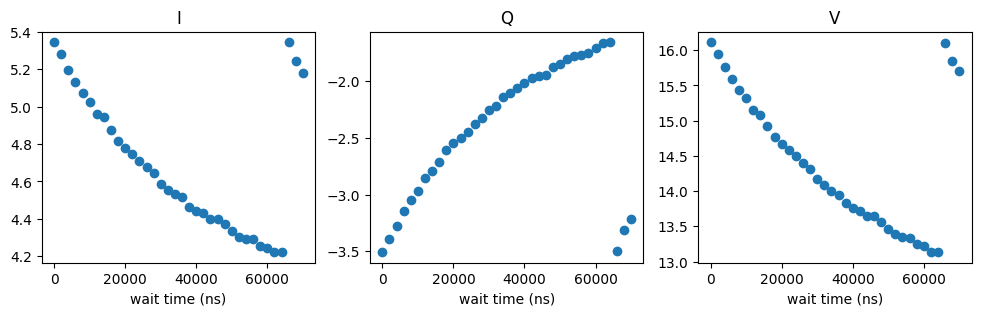

In [172]:
# Wait_duration_list = np.linspace(Wait_start, Wait_stop, Wait_step, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
data = [i_vec, q_vec, v_vec]
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
titles = ["I", "Q", "V"]

for i in range(3):
    axes[i].plot(xaxis, data[i], "o")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("wait time (ns)")
# plt.figure(figsize=(3, 3))
# plt.plot(i_vec, q_vec, "o")
# plt.xlabel("I")
# plt.ylabel("Q")

Text(0, 0.5, 'Prob($|1\\rangle$)')

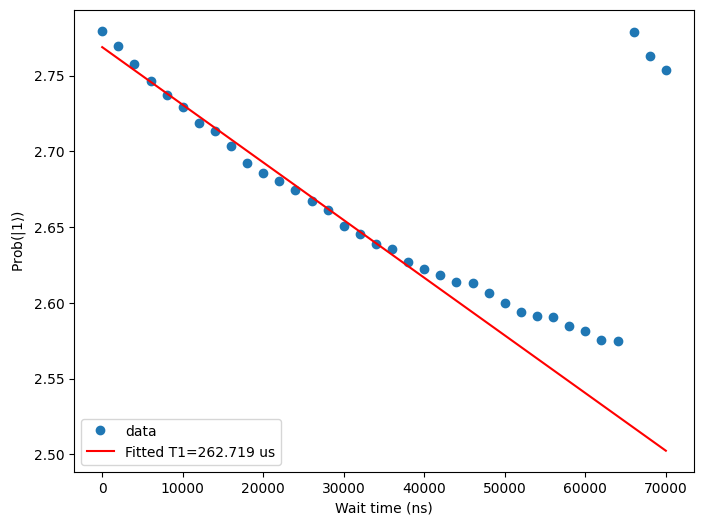

In [168]:
fit_up2 = -14
coeffs_fit = np.polyfit(xaxis[:fit_up2], np.log(v_vec[:fit_up2]), 1)
poly1d_fn = np.poly1d(coeffs_fit)  # poly1d_fn is now a function which takes in x and returns an estimate for y
exponent = coeffs_fit[0]
T1 = -1 / exponent

# Plot the data and the fitted function
plt.figure(figsize=(8, 6))
plt.plot(xaxis, np.log(v_vec), "o", label="data")
plt.plot(xaxis, poly1d_fn(xaxis), "r", label=f"Fitted T1={T1/1000:.3f} us")
plt.legend()
plt.xlabel("Wait time (ns)")
plt.ylabel("Prob($|1\\rangle$)")

In [ ]:
# Wait_duration_list = np.linspace(Wait_start, Wait_stop, Wait_step, endpoint=True)
fig, axes = plt.subplots(1, 3, figsize=(12, 3))
data = [i_vec, q_vec, v_vec]
xaxis = np.arange(wait_start, wait_stop + wait_step, wait_step)
titles = ["I", "Q", "V"]

for i in range(3):
    axes[i].plot(xaxis, data[i], "o")
    axes[i].set_title(titles[i])
    axes[i].set_xlabel("wait time (ns)")
# plt.figure(figsize=(3, 3))
# plt.plot(i_vec, q_vec, "o")
# plt.xlabel("I")
# plt.ylabel("Q")